In [1]:
%store -r merged_df

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

#pmdarima library
import pmdarima as pm
#ARIMA-statsmodels
from statsmodels.tsa.arima_model import ARIMA
#MSE
from sklearn.metrics import mean_squared_error
#seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose



## MODEL PREP AND MODELING DATA



Reindex with qtr_begin_dt. Group by product_fda_list_name and qtr_begin_dt to sum units/amounts. Split by DEA Schedule, MAT vs non-MAT. Create smaller subset that is date and units_per_1000

Split into train vs test by date -- test data is 2019 and later, train data is everything prior to 1.1.2019

In [3]:
grouped_df = merged_df.groupby(['qtr_begin_dt','mat_x','opioid','dea_schedule','product_fda_list_name']).sum()


In [4]:
grp_dea_sched_df = merged_df.groupby(['qtr_begin_dt','mat_x','opioid','dea_schedule','enrollment']).sum().reset_index()

In [5]:
grp_dea_sched_test_df = grp_dea_sched_df.loc[grp_dea_sched_df['qtr_begin_dt']> '2018-12-31']
grp_dea_sched_test_df.set_index(pd.DatetimeIndex(grp_dea_sched_test_df['qtr_begin_dt']), inplace = True)
grp_dea_sched_test_df.drop(columns = ['qtr_begin_dt'], inplace = True)
grp_dea_sched_df = grp_dea_sched_df.loc[grp_dea_sched_df['qtr_begin_dt']< '2018-12-31']
grp_dea_sched_df.set_index(pd.DatetimeIndex(grp_dea_sched_df['qtr_begin_dt']), inplace = True)
grp_dea_sched_df.drop(columns = ['qtr_begin_dt'], inplace = True)

/Users/shishi/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [6]:
CII = grp_dea_sched_df.loc[grp_dea_sched_df['dea_schedule']== 'CII']
CIII = grp_dea_sched_df.loc[grp_dea_sched_df['dea_schedule']== 'CIII']

CIV = grp_dea_sched_df.loc[grp_dea_sched_df['dea_schedule']== 'CIV']

CV = grp_dea_sched_df.loc[grp_dea_sched_df['dea_schedule']== 'CV']

MAT_df = grp_dea_sched_df.loc[grp_dea_sched_df['mat_x'] == 1]
Non_MAT_df = grp_dea_sched_df.loc[grp_dea_sched_df['mat_x']==0]

MAT_test_df = grp_dea_sched_test_df.loc[grp_dea_sched_test_df['mat_x'] == 1]
Non_MAT_test_df = grp_dea_sched_test_df.loc[grp_dea_sched_test_df['mat_x']==0]

First approach is to trend/forecast based on each class of drugs. 

In [7]:
CII_Non_MAT = CII.loc[CII['mat_x']== 0]
CIII_Non_MAT = CIII.loc[CIII['mat_x']== 0]
CIV_Non_MAT = CIV.loc[CIV['mat_x']== 0]
CV_Non_MAT = CV.loc[CV['mat_x']== 0]



In [8]:
CV_Non_MAT['units_per_1000'].unique()

array([ 53.11518223,  76.35317047,  82.45402029, 105.66775389,
       319.17759739,  32.10821545,   9.62239438,   9.93500471,
       340.55170718, 215.20966192, 167.84324158, 238.42999096,
       238.44368746, 134.54807484, 114.1781621 , 165.77280316])

In [9]:
CII_Non_MAT.loc[:,"units_per_1000"] = pd.to_numeric(CII_Non_MAT["units_per_1000"], errors = "coerce")
CIII_Non_MAT.loc[:,"units_per_1000"] = pd.to_numeric(CIII_Non_MAT["units_per_1000"], errors = "coerce")
CIV_Non_MAT.loc[:,"units_per_1000"] = pd.to_numeric(CIV_Non_MAT["units_per_1000"], errors = "coerce")
CV_Non_MAT.loc[:,"units_per_1000"] = pd.to_numeric(CV_Non_MAT["units_per_1000"], errors = "coerce")

/Users/shishi/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


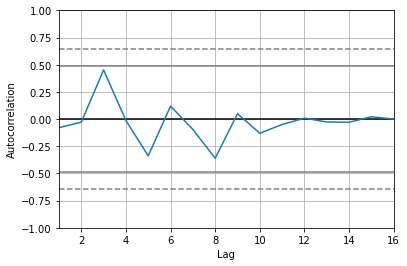

In [10]:
pd.plotting.autocorrelation_plot(CIV_Non_MAT.units_per_1000);

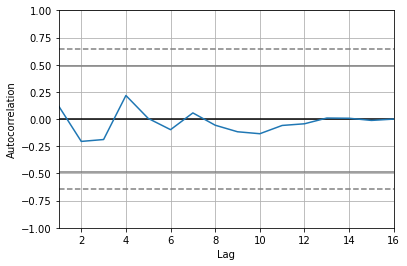

In [11]:
pd.plotting.autocorrelation_plot(CV_Non_MAT.units_per_1000);

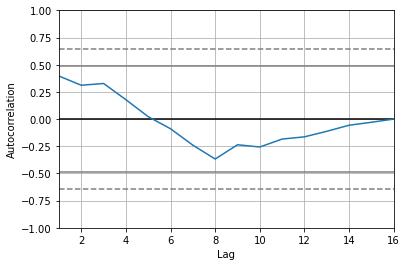

In [12]:
pd.plotting.autocorrelation_plot(CIII_Non_MAT.units_per_1000);

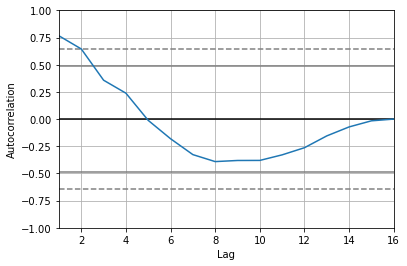

In [13]:
pd.plotting.autocorrelation_plot(CII_Non_MAT.units_per_1000);

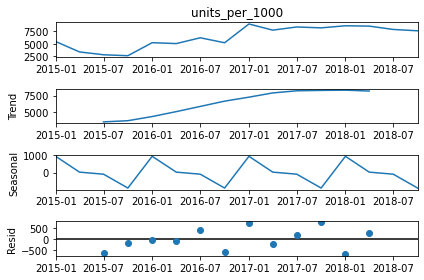

In [14]:
# Decompose time series into trend, seasonal, and residual components.
decomp = seasonal_decompose(CII_Non_MAT['units_per_1000'])

# Plot the decomposed time series.
decomp.plot();

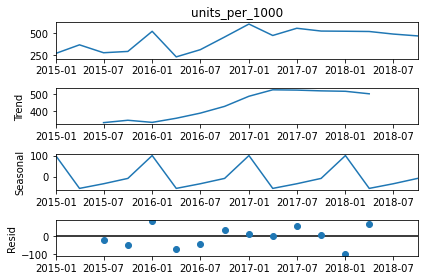

In [15]:
# Decompose time series into trend, seasonal, and residual components.
decomp = seasonal_decompose(CIII_Non_MAT['units_per_1000'])

# Plot the decomposed time series.
decomp.plot();

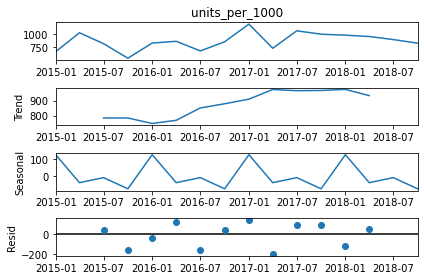

In [16]:
# Decompose time series into trend, seasonal, and residual components.
decomp = seasonal_decompose(CIV_Non_MAT['units_per_1000'])

# Plot the decomposed time series.
decomp.plot();

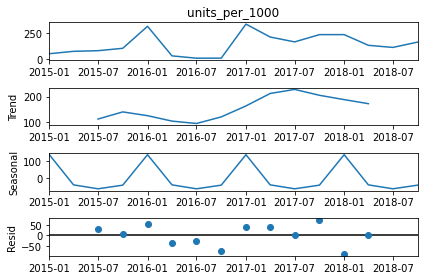

In [17]:
# Decompose time series into trend, seasonal, and residual components.
decomp = seasonal_decompose(CV_Non_MAT['units_per_1000'])

# Plot the decomposed time series.
decomp.plot();

Based on the decomposition and autocorrelation plots, the seasonality and trend for each class is generally similar. Instead of a breakdown by class, trend and forecast based on all opioids dispensed. Use MAT vs non-MAT to classify. 

Using functions from statsmodels.api documentation, performing Dickey-Fuller and KPSS to test for stationarity with MAT vs Non_MAT timeseries. 

In [18]:
MAT_df = MAT_df.groupby(['qtr_begin_dt','mat_x','opioid','enrollment']).sum()
MAT_df = MAT_df[['units_per_1000']]




In [19]:
Non_MAT_df = Non_MAT_df.groupby(['qtr_begin_dt','mat_x','opioid','enrollment']).sum()
Non_MAT_df = Non_MAT_df[['units_per_1000']]

In [20]:
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [21]:
from statsmodels.tsa.stattools import kpss
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

In [22]:
adf_test(MAT_df)

Results of Dickey-Fuller Test:
Test Statistic                -1.039846e+01
p-value                        1.937323e-18
#Lags Used                     6.000000e+00
Number of Observations Used    9.000000e+00
Critical Value (1%)           -4.473135e+00
Critical Value (5%)           -3.289881e+00
Critical Value (10%)          -2.772382e+00
dtype: float64


In [23]:
kpss_test(MAT_df)

Results of KPSS Test:
Test Statistic           0.512357
p-value                  0.038884
Lags Used                2.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


In [24]:
adf_test(Non_MAT_df)

Results of Dickey-Fuller Test:
Test Statistic                -1.623165
p-value                        0.471070
#Lags Used                     6.000000
Number of Observations Used    9.000000
Critical Value (1%)           -4.473135
Critical Value (5%)           -3.289881
Critical Value (10%)          -2.772382
dtype: float64


In [25]:
kpss_test(Non_MAT_df)

Results of KPSS Test:
Test Statistic           0.502715
p-value                  0.041055
Lags Used                2.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


MAT data appears to be stationary. Non_MAT data does not. Trying differencing by subtracting one shift and then 2 shifts. Plot. 

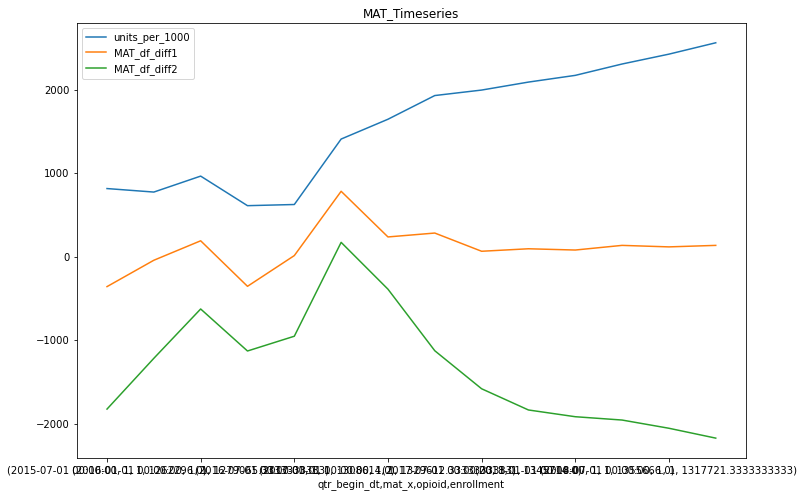

In [26]:
MAT_df['MAT_df_diff1'] = MAT_df['units_per_1000'] - MAT_df['units_per_1000'].shift(1)
MAT_df['MAT_df_diff2'] = MAT_df['MAT_df_diff1'] - MAT_df['units_per_1000'].shift(2)
MAT_df= MAT_df.dropna()
MAT_df['units_per_1000'].plot(figsize =(12,8), legend = True, title = 'MAT_Timeseries')
MAT_df['MAT_df_diff1'].plot(figsize = (12,8), legend = True)
MAT_df['MAT_df_diff2'].plot(figsize = (12,8), legend = True)

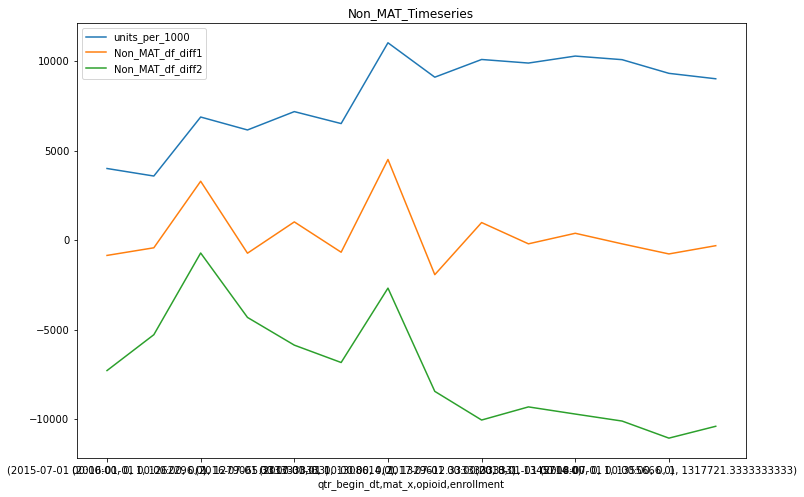

In [27]:
Non_MAT_df['Non_MAT_df_diff1'] = Non_MAT_df['units_per_1000'] - Non_MAT_df['units_per_1000'].shift(1) 
Non_MAT_df['Non_MAT_df_diff2'] = Non_MAT_df['Non_MAT_df_diff1'] - Non_MAT_df['units_per_1000'].shift(2)
Non_MAT_df= Non_MAT_df.dropna()
Non_MAT_df['units_per_1000'].plot(figsize = (12,8), legend = True, title = 'Non_MAT_Timeseries')
Non_MAT_df['Non_MAT_df_diff1'].plot(figsize = (12,8), legend = True)
Non_MAT_df['Non_MAT_df_diff2'].plot(figsize = (12,8), legend = True)

In [28]:
adf_test(Non_MAT_df['Non_MAT_df_diff1'])

Results of Dickey-Fuller Test:
Test Statistic                -6.082401e+00
p-value                        1.084306e-07
#Lags Used                     0.000000e+00
Number of Observations Used    1.300000e+01
Critical Value (1%)           -4.068854e+00
Critical Value (5%)           -3.127149e+00
Critical Value (10%)          -2.701730e+00
dtype: float64


In [29]:
kpss(Non_MAT_df['Non_MAT_df_diff1'])

/Users/shishi/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/Users/shishi/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


(0.2930191498731202,
 0.1,
 8,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [30]:
adf_test(Non_MAT_df['Non_MAT_df_diff2'])

Results of Dickey-Fuller Test:
Test Statistic                -0.907546
p-value                        0.785477
#Lags Used                     5.000000
Number of Observations Used    8.000000
Critical Value (1%)           -4.665186
Critical Value (5%)           -3.367187
Critical Value (10%)          -2.802961
dtype: float64


In [31]:
kpss_test(Non_MAT_df['Non_MAT_df_diff2'])

Results of KPSS Test:
Test Statistic           0.574728
p-value                  0.024934
Lags Used                1.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


In [32]:
adf_test(MAT_df['MAT_df_diff1'])

Results of Dickey-Fuller Test:
Test Statistic                -1.129444e+01
p-value                        1.354585e-20
#Lags Used                     5.000000e+00
Number of Observations Used    8.000000e+00
Critical Value (1%)           -4.665186e+00
Critical Value (5%)           -3.367187e+00
Critical Value (10%)          -2.802961e+00
dtype: float64


In [33]:
kpss_test(MAT_df['MAT_df_diff1'])

Results of KPSS Test:
Test Statistic           0.222159
p-value                  0.100000
Lags Used                0.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


/Users/shishi/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


In [34]:
adf_test(MAT_df['MAT_df_diff2'])

Results of Dickey-Fuller Test:
Test Statistic                -1.819249e+01
p-value                        2.417290e-30
#Lags Used                     5.000000e+00
Number of Observations Used    8.000000e+00
Critical Value (1%)           -4.665186e+00
Critical Value (5%)           -3.367187e+00
Critical Value (10%)          -2.802961e+00
dtype: float64


In [35]:
kpss_test((MAT_df['MAT_df_diff2']))

Results of KPSS Test:
Test Statistic           0.386997
p-value                  0.082760
Lags Used                1.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


### GRIDSEARCH FOR OPTIMAL SARIMA HYPERPARAMETERS

Credit to [Jason Brownlee](https://machinelearningmastery.com/how-to-grid-search-sarima-model-hyperparameters-for-time-series-forecasting-in-python/) for the code below:

Each timeseries is gridsearched for optimal SARIMA hyperparamaters using RMSE as a measure of accuracy. For each test, 

In [ ]:
# # grid search sarima hyperparameters
# from math import sqrt
# from multiprocessing import cpu_count
# from joblib import Parallel
# from joblib import delayed
# from warnings import catch_warnings
# from warnings import filterwarnings
# from statsmodels.tsa.statespace.sarimax import SARIMAX
# from sklearn.metrics import mean_squared_error

# # one-step sarima forecast
# def sarima_forecast(history, config):
# 	order, sorder, trend = config
# 	# define model
# 	model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
# 	# fit model
# 	model_fit = model.fit(disp=False)
# 	# make one step forecast
# 	yhat = model_fit.predict(len(history), len(history))
# 	return yhat[0]

# # root mean squared error or rmse
# def measure_rmse(actual, predicted):
# 	return sqrt(mean_squared_error(actual, predicted))

# # split a univariate dataset into train/test sets
# def train_test_split(data, n_test):
# 	return data[:-n_test], data[-n_test:]

# # walk-forward validation for univariate data
# def walk_forward_validation(data, n_test, cfg):
# 	predictions = list()
# 	# split dataset
# 	train, test = train_test_split(data, n_test)
# 	# seed history with training dataset
# 	history = [x for x in train]
# 	# step over each time-step in the test set
# 	for i in range(len(test)):
# 		# fit model and make forecast for history
# 		yhat = sarima_forecast(history, cfg)
# 		# store forecast in list of predictions
# 		predictions.append(yhat)
# 		# add actual observation to history for the next loop
# 		history.append(test[i])
# 	# estimate prediction error
# 	error = measure_rmse(test, predictions)
# 	return error

# # score a model, return None on failure
# def score_model(data, n_test, cfg, debug=False):
# 	result = None
# 	# convert config to a key
# 	key = str(cfg)
# 	# show all warnings and fail on exception if debugging
# 	if debug:
# 		result = walk_forward_validation(data, n_test, cfg)
# 	else:
# 		# one failure during model validation suggests an unstable config
# 		try:
# 			# never show warnings when grid searching, too noisy
# 			with catch_warnings():
# 				filterwarnings("ignore")
# 				result = walk_forward_validation(data, n_test, cfg)
# 		except:
# 			error = None
# 	# check for an interesting result
# 	if result is not None:
# 		#print(' > Model[%s] %.3f' % (key, result))
# 	return (key, result)

# # grid search configs
# def grid_search(data, cfg_list, n_test, parallel=False):
# 	scores = None
# 	if parallel:
# 		# execute configs in parallel
# 		executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
# 		tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
# 		scores = executor(tasks)
# 	else:
# 		scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
# 	# remove empty results
# 	scores = [r for r in scores if r[1] != None]
# 	# sort configs by error, asc
# 	scores.sort(key=lambda tup: tup[1])
# 	return scores

# # create a set of sarima configs to try
# def sarima_configs(seasonal=[4]):
# 	models = list()
# 	# define config lists
# 	p_params = [0, 1, 2]
# 	d_params = [0, 1]
# 	q_params = [0, 1, 2]
# 	t_params = ['n','c','t','ct'] #‘n’,’c’,’t’,’ct’ for no trend, constant, linear, and constant with linear trend
# 	P_params = [0, 1, 2]
# 	D_params = [0, 1]
# 	Q_params = [0, 1, 2]
# 	m_params = seasonal
# 	# create config instances
# 	for p in p_params:
# 		for d in d_params:
# 			for q in q_params:
# 				for t in t_params:
# 					for P in P_params:
# 						for D in D_params:
# 							for Q in Q_params:
# 								for m in m_params:
# 									cfg = [(p,d,q), (P,D,Q,m), t]
# 									models.append(cfg)
# 	return models



Test each timeseries and differentiation:

In [ ]:
# if __name__ == '__main__':
# 	# define dataset
# 	data = Non_MAT_df['units_per_1000']
# 	#print(data)
# 	# data split
# 	n_test = 3
# 	# model configs
# 	cfg_list = sarima_configs()
# 	# grid search
# 	scores = grid_search(data, cfg_list, n_test)
# 	print('done')
# 	# list top 3 configs
# 	for cfg, error in scores[:3]:
# 		print(cfg, error)

In [ ]:
# if __name__ == '__main__':
# 	# define dataset
# 	data = Non_MAT_df['Non_MAT_df_diff1']
# 	print(data)
# 	# data split
# 	n_test = 4
# 	# model configs
# 	cfg_list = sarima_configs()
# 	# grid search
# 	scores = grid_search(data, cfg_list, n_test)
# 	print('done')
# 	# list top 3 configs
# 	for cfg, error in scores[:3]:
# 		print(cfg, error)

In [ ]:
# if __name__ == '__main__':
# 	# define dataset
# 	data = Non_MAT_df['Non_MAT_df_diff2']
# 	print(data)
# 	# data split
# 	n_test = 3
# 	# model configs
# 	cfg_list = sarima_configs()
# 	# grid search
# 	scores = grid_search(data, cfg_list, n_test)
# 	print('done')
# 	# list top 3 configs
# 	for cfg, error in scores[:3]:
# 		print(cfg, error)

In [ ]:
# if __name__ == '__main__':
# 	# define dataset
# 	data = MAT_df['units_per_1000']
# 	print(data)
# 	# data split
# 	n_test = 3
# 	# model configs
# 	cfg_list = sarima_configs()
# 	# grid search
# 	scores = grid_search(data, cfg_list, n_test)
# 	print('done')
# 	# list top 3 configs
# 	for cfg, error in scores[:3]:
# 		print(cfg, error)

In [ ]:
# if __name__ == '__main__':
# 	# define dataset
# 	data = MAT_df['MAT_df_diff1']
# 	print(data)
# 	# data split
# 	n_test = 3
# 	# model configs
# 	cfg_list = sarima_configs()
# 	# grid search
# 	scores = grid_search(data, cfg_list, n_test)
# 	print('done')
# 	# list top 3 configs
# 	for cfg, error in scores[:3]:
# 		print(cfg, error)

In [ ]:
# if __name__ == '__main__':
# 	# define dataset
# 	data = MAT_df['MAT_df_diff2']
# 	print(data)
# 	# data split
# 	n_test = 4
# 	# model configs
# 	cfg_list = sarima_configs()
# 	# grid search
# 	scores = grid_search(data, cfg_list, n_test)
# 	print('done')
# 	# list top 3 configs
# 	for cfg, error in scores[:3]:
# 		print(cfg, error)

The most accurate SARIMA model parameters for the non_MAT data are [(0, 1, 2), (0, 0, 0, 0), 'c']  with RMSE 754.0504596596611 using the first differential (test set size = 4 entries)
The most accurate SARIMA model parameters for the MAT data are [(1, 0, 2), (0, 0, 0, 0), 't'] with RMSE 371.7871153398942 using the second differential (test set size = 4 entries)
Interpret the parameters as cfg = [(p,d,q), (P,D,Q,m), t], where 
p: Trend autoregression order.
d: Trend difference order.
q: Trend moving average order.

P: Seasonal autoregressive order.
D: Seasonal difference order.
Q: Seasonal moving average order.
m: The number of time steps for a single seasonal period.

and t  = ‘n’,’c’,’t’,’ct’ for no trend, constant, linear, and constant with linear trend

Both of my best-performing models have 0s in all the seasonal parameters, meaning that a SARIMA isn't the best performing model and a regular ARIMA model is more accurate.

[Jason Brownlee](https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/) has an excellent rolling forecast model using ARIMA that I attempted to apply here. However, I encountered quite a few errors, that I believe is attributed to having such a small dataset.


In [ ]:
# X = Non_MAT_df['Non_MAT_df_diff1'].values

# size = 15
# train, test = X[0:size], X[size:len(X)]
# history = [x for x in train]
# predictions = list()
# for t in range(len(test)):
# 	model = ARIMA(history, order=(0,1,2))
# 	model_fit = model.fit(disp=0)
# 	output = model_fit.forecast()
# 	yhat = output[0]
# 	predictions.append(yhat)
# 	obs = test[t]
# 	history.append(obs)
# 	print('predicted=%f, expected=%f' % (yhat, obs))
# error = np.sqrt(mean_squared_error(test, predictions))
# print(f'Test RMSE:  {error}')
# # plot
# plt.plot(test)
# plt.plot(predictions, color='red')
# plt.show()

### USING PMDARIMA

Using [pmdarima](https://alkaline-ml.com/pmdarima/index.html), which is a library that brings the functionality of R's auto.arima to Python. The auto-differentiator piece of the pmdarima library means we don't have to evaluate each step separately as above. Also, PMDARIMA calculated much faster than the function referenced above.

In [36]:
#Since this model will auto calculate the differentiated columns, no need to drop rows as above.
#Recreating my data frames here to use with pmdarima. Also transforming 2020 data to use in analysis

MAT_df = grp_dea_sched_df.loc[grp_dea_sched_df['mat_x'] == 1]
Non_MAT_df = grp_dea_sched_df.loc[grp_dea_sched_df['mat_x']==0]


MAT_df = MAT_df[['units_per_1000']].groupby('qtr_begin_dt').sum()
Non_MAT_df = Non_MAT_df[['units_per_1000']].groupby('qtr_begin_dt').sum()

MAT_test_df = grp_dea_sched_test_df.loc[grp_dea_sched_test_df['mat_x']==1]
Non_MAT_test_df = grp_dea_sched_test_df.loc[grp_dea_sched_test_df['mat_x']==0]

MAT_test_df = MAT_test_df[['units_per_1000']].groupby('qtr_begin_dt').sum()
Non_MAT_test_df = Non_MAT_test_df[['units_per_1000']].groupby('qtr_begin_dt').sum()





Autocorrelation plots

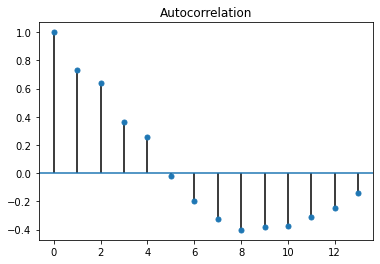

In [37]:
pm.plot_acf(Non_MAT_df['units_per_1000'])

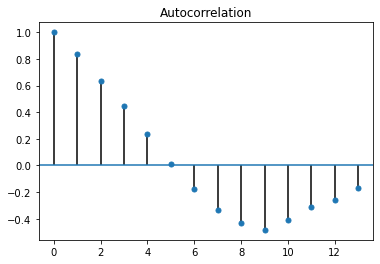

In [38]:
pm.plot_acf(MAT_df['units_per_1000'])

In [39]:
#fit Non_MAT_first. Start with d=0, test up to 2nd differentiation. Use 4 for m as 4 quarters complete a year
stepwise_fit = pm.auto_arima(Non_MAT_df['units_per_1000'], start_p=1, start_q=1,
                             max_p=2, max_q=2, m=4,
                             start_P=0, seasonal= True,
                             d=2, D=1, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,1,1)[4]             : AIC=inf, Time=0.10 sec
 ARIMA(0,2,0)(0,1,0)[4]             : AIC=189.950, Time=0.01 sec
 ARIMA(1,2,0)(1,1,0)[4]             : AIC=182.269, Time=0.05 sec
 ARIMA(0,2,1)(0,1,1)[4]             : AIC=inf, Time=0.05 sec
 ARIMA(1,2,0)(0,1,0)[4]             : AIC=184.042, Time=0.01 sec
 ARIMA(1,2,0)(2,1,0)[4]             : AIC=182.909, Time=0.06 sec
 ARIMA(1,2,0)(1,1,1)[4]             : AIC=182.419, Time=0.10 sec
 ARIMA(1,2,0)(0,1,1)[4]             : AIC=inf, Time=0.05 sec
 ARIMA(1,2,0)(2,1,1)[4]             : AIC=184.357, Time=0.13 sec
 ARIMA(0,2,0)(1,1,0)[4]             : AIC=186.607, Time=0.03 sec
 ARIMA(2,2,0)(1,1,0)[4]             : AIC=182.831, Time=0.02 sec
 ARIMA(1,2,1)(1,1,0)[4]             : AIC=181.385, Time=0.06 sec
 ARIMA(1,2,1)(0,1,0)[4]             : AIC=183.034, Time=0.06 sec
 ARIMA(1,2,1)(2,1,0)[4]             : AIC=183.273, Time=0.10 sec
 ARIMA(1,2,1)(1,1,1)[4]             : AIC=182.299, Time=0.1

In [40]:
#fit MAT. Start with d=0, test up to 2nd differentiation Use 4 for m as 4 quarters complete a year
stepwise_fit = pm.auto_arima(MAT_df['units_per_1000'], start_p=1, start_q=1,
                             max_p=2, max_q=2, m=4,
                             start_P=0, seasonal=True,
                             d=2, D=1, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,1,1)[4]             : AIC=inf, Time=0.11 sec
 ARIMA(0,2,0)(0,1,0)[4]             : AIC=154.941, Time=0.01 sec
 ARIMA(1,2,0)(1,1,0)[4]             : AIC=155.332, Time=0.03 sec
 ARIMA(0,2,1)(0,1,1)[4]             : AIC=inf, Time=0.04 sec
 ARIMA(0,2,0)(1,1,0)[4]             : AIC=154.397, Time=0.02 sec
 ARIMA(0,2,0)(2,1,0)[4]             : AIC=inf, Time=nan sec
 ARIMA(0,2,0)(1,1,1)[4]             : AIC=inf, Time=0.08 sec
 ARIMA(0,2,0)(0,1,1)[4]             : AIC=inf, Time=0.03 sec
 ARIMA(0,2,0)(2,1,1)[4]             : AIC=155.501, Time=0.12 sec
 ARIMA(0,2,1)(1,1,0)[4]             : AIC=154.300, Time=0.04 sec
 ARIMA(0,2,1)(0,1,0)[4]             : AIC=154.878, Time=0.02 sec
 ARIMA(0,2,1)(2,1,0)[4]             : AIC=152.860, Time=0.07 sec
 ARIMA(0,2,1)(2,1,1)[4]             : AIC=154.831, Time=0.13 sec
 ARIMA(0,2,1)(1,1,1)[4]             : AIC=inf, Time=0.10 sec
 ARIMA(1,2,1)(2,1,0)[4]             : AIC=inf, Time=0.11 sec
 ARIMA(0,2,

Cross-Validation and predictions - from [pmdarima](https://alkaline-ml.com/pmdarima/auto_examples/model_selection/example_cross_val_predict.html#sphx-glr-auto-examples-model-selection-example-cross-val-predict-py) documentation

pmdarima version: 1.7.1


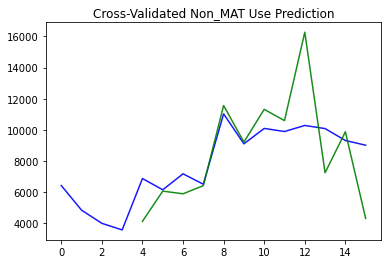

In [41]:
# Author: Taylor Smith <taylor.smith@alkaline-ml.com>
##NON_MAT 

import numpy as np
import pmdarima as pm
from pmdarima import model_selection
from matplotlib import pyplot as plt

print("pmdarima version: %s" % pm.__version__)

# Load the data and split it into separate pieces
y = Non_MAT_df[['units_per_1000']]
est = pm.ARIMA(order=(1, 2, 1),
               seasonal_order=(1, 1, 0, 4),
               suppress_warnings=True)
cv = model_selection.SlidingWindowForecastCV(window_size = 4, step = 1, h =4) #h is the number of steps to predict
predictions_Non_MAT = model_selection.cross_val_predict(est, y, cv=cv)

# plot the predictions over the original series
x_axis = np.arange(y.shape[0])
n_test = predictions_Non_MAT.shape[0]

plt.plot(x_axis, y, alpha=0.9, c='b')
plt.plot(x_axis[-n_test:], predictions_Non_MAT, alpha=0.9, c='g')  # Forecasts
plt.title("Cross-Validated Non_MAT Use Prediction")
plt.show()


pmdarima version: 1.7.1


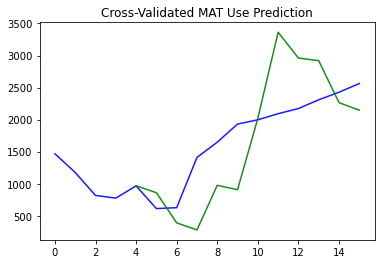

In [42]:
# Author: Taylor Smith <taylor.smith@alkaline-ml.com>

print("pmdarima version: %s" % pm.__version__)

# Load the data and split it into separate pieces
y = MAT_df['units_per_1000']
est = pm.ARIMA(order=(0, 2, 1),
               seasonal_order=(2, 1, 0, 4),
               suppress_warnings=True)
cv = model_selection.SlidingWindowForecastCV(window_size = 4, step = 1, h =4) #h is the number of steps to predict
predictions_MAT = model_selection.cross_val_predict(est, y, cv=cv)

# plot the predictions over the original series
x_axis = np.arange(y.shape[0])
n_test = predictions_MAT.shape[0]

plt.plot(x_axis, y, alpha=0.9, c='b')
plt.plot(x_axis[-n_test:], predictions_MAT, alpha=0.9, c='g')  # Forecasts
plt.title("Cross-Validated MAT Use Prediction")
plt.show()



Each of these predictors takes the data from 2015 - 2018 to predict 2019- 2020 expected use. 

### ANALYSIS OF PREDICTIONS

In [59]:
preds_MAT = pd.DataFrame(predictions_MAT[7:12]).astype("float")

In [60]:
preds_MAT = preds_MAT.rename(columns = {0:"units_per_1000"}) 
preds_MAT


units_per_1000
0     3363.195936
1     2960.766468
2     2920.309684
3     2264.970430
4     2147.237921

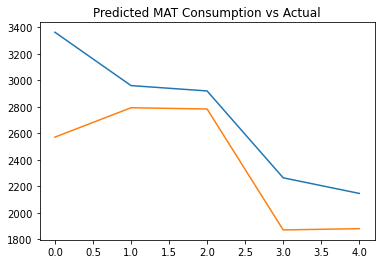

In [64]:
fig, ax = plt.subplots()
x = [0,1,2,3,4]
ax.plot(x, preds_MAT['units_per_1000'])
ax.plot(x, MAT_test_df['units_per_1000'])

ax.set_title("Predicted MAT Consumption vs Actual")

plt.show()

In [66]:
preds_Non_MAT = pd.DataFrame(predictions_Non_MAT[7:12]).astype("float")
preds_Non_MAT = preds_Non_MAT.rename(columns = {0:"units_per_1000"}) 
preds_Non_MAT

units_per_1000
0    10599.260392
1    16267.839771
2     7254.645375
3     9883.145106
4     4325.009496

In [87]:

x = [0,1,2,3,4]
y1 = preds_Non_MAT['units_per_1000']
y2 = Non_MAT_test_df['units_per_1000']
y3 = preds_MAT['units_per_1000']
y4 = MAT_test_df['units_per_1000']


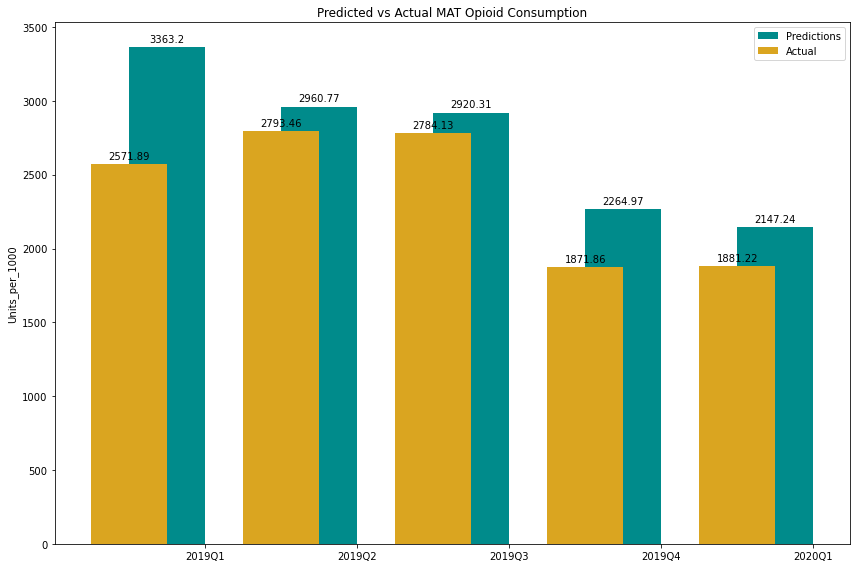

In [88]:
x_labels = ['2019Q1','2019Q2','2019Q3','2019Q4','2020Q1']
x = np.arange(len(x_labels))
width = 0.5

fig, ax = plt.subplots(figsize = (12,8))
bar1 = ax.bar(x-width/2, y3, width, label = "Predictions", color = 'darkcyan')
bar2 = ax.bar(x-width, y4, width, label = "Actual", color = 'goldenrod')

ax.set_ylabel('Units_per_1000')
ax.set_title('Predicted vs Actual MAT Opioid Consumption')
ax.set_xticks(x)
ax.set_xticklabels(x_labels)
ax.legend()

def labeller(bars):
    """Labels the height of each bar"""
    for b in bars:
        height = round(b.get_height(),2)
        ax.annotate('{}'.format(height),
                   xy=(b.get_x() + b.get_width() /2, height),
                    xytext=(0,3),
                    textcoords = "offset points",
                    ha = 'center' , va = 'bottom')


labeller(bar1)
labeller(bar2)

fig.tight_layout()
plt.show()



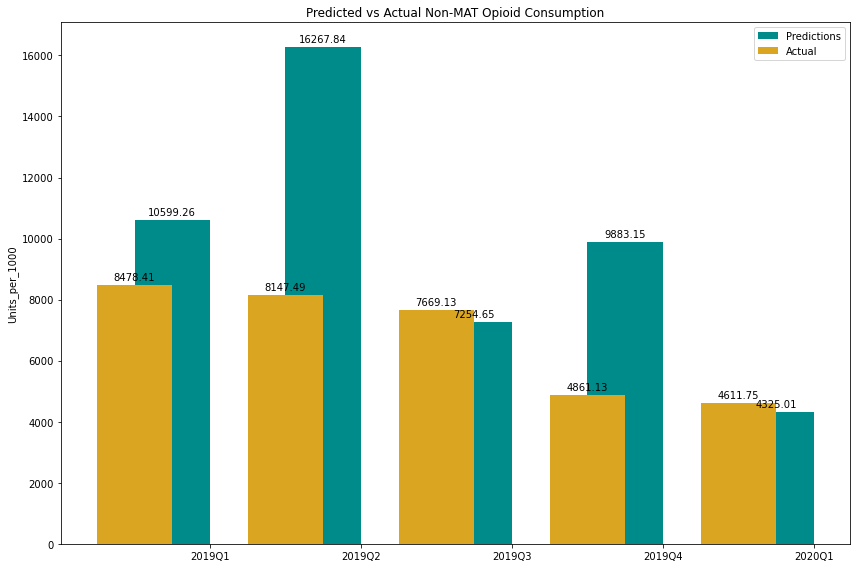

In [86]:
x_labels = ['2019Q1','2019Q2','2019Q3','2019Q4','2020Q1']
x = np.arange(len(x_labels))
width = 0.5

fig, ax = plt.subplots(figsize = (12,8))
bar1 = ax.bar(x-width/2, y1, width, label = "Predictions", color = 'darkcyan')
bar2 = ax.bar(x-width, y2, width, label = "Actual", color = 'goldenrod')

ax.set_ylabel('Units_per_1000')
ax.set_title('Predicted vs Actual Non-MAT Opioid Consumption')
ax.set_xticks(x)
ax.set_xticklabels(x_labels)
ax.legend()

def labeller(bars):
    """Labels the height of each bar"""
    for b in bars:
        height = round(b.get_height(),2)
        ax.annotate('{}'.format(height),
                   xy=(b.get_x() + b.get_width() /2, height),
                    xytext=(0,3),
                    textcoords = "offset points",
                    ha = 'center' , va = 'bottom')


labeller(bar1)
labeller(bar2)

fig.tight_layout()
plt.show()


In [ ]:
x_labels = ['2019Q1','2019Q2','2019Q3','2019Q4','2020Q1']
x = np.arange(len(x_labels))
width = 0.5

fig, ax = plt.subplots(figsize = (12,8))
bar1 = ax.bar(x-width/2, y1, width, label = "Predictions", color = 'darkcyan')
bar2 = ax.bar(x-width, y2, width, label = "Actual", color = 'goldenrod')

ax.set_ylabel('Units_per_1000')
ax.set_title('Predicted vs Actual MAT Opioid Consumption')
ax.set_xticks(x)
ax.set_xticklabels(x_labels)
ax.legend()

def labeller(bars):
    """Labels the height of each bar"""
    for b in bars:
        height = round(b.get_height(),2)
        ax.annotate('{}'.format(height),
                   xy=(b.get_x() + b.get_width() /2, height),
                    xytext=(0,3),
                    textcoords = "offset points",
                    ha = 'center' , va = 'bottom')


labeller(bar1)
labeller(bar2)

fig.tight_layout()
plt.show()

